# 1. Data preparation:  
1. Importing Data from the folders 
2. resampling the Imported Data 

In [1]:
import os
import cv2
import numpy as np

data_dir = "/kaggle/input/ecuadorian-facial-expression-efe-dataset/efe_dataset"
images = []
labels = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                # Redimensionnez l'image au besoin, par exemple, (128, 128)
                image = cv2.resize(image, (128, 128))
                # Convertissez l'image en tableau NumPy
                image_array = np.array(image)
                images.append(image_array)
                labels.append(label)

# Convertissez la liste d'images et de labels en tableaux NumPy
images = np.array(images)
labels = np.array(labels)  

set(labels) 
images.shape

(246, 128, 128, 3)

In [2]:
images.shape

(246, 128, 128, 3)

### We resample the data:

In [3]:
random_indices = np.arange(images.shape[0])
np.random.shuffle(random_indices)
images = images[random_indices]
labels = labels[random_indices] 

# 2.Data Augmentation 

The data we have is not sufficient for training the model, so we use Image Data Augmentation:

**Image Data Augmentation:** This involves using existing data to generate new data, and it is commonly used with image data. Augmentation for images typically includes operations such as rotation, noise addition, zooming, and adjustments to spatial attributes, among others.

In [4]:
from tqdm import tqdm 
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



augmented_data_generator = datagen.flow(images, labels, batch_size=50)

# Define the number of batches you want to generate
num_batches = 200

# Create a list to store all augmented images and labels
all_augmented_images = []
all_augmented_labels = []

# Generate and collect augmented data
for _ in tqdm(range(num_batches)):
    augmented_images, augmented_labels = next(augmented_data_generator)
    all_augmented_images.append(augmented_images)
    all_augmented_labels.append(augmented_labels)

# Combine the batches into a single array
all_augmented_images = np.vstack(all_augmented_images)
all_augmented_labels = np.hstack(all_augmented_labels)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


In [5]:
combined_images = np.vstack((images, all_augmented_images))
combined_labels = np.hstack((labels, all_augmented_labels)) 

del all_augmented_images
del all_augmented_labels 

combined_images.shape 
set(combined_labels)

{'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'}

In [6]:
from sklearn.model_selection import train_test_split 
random_indices = np.arange(combined_images.shape[0])
np.random.shuffle(random_indices)
combined_images = combined_images[random_indices]
combined_labels = combined_labels[random_indices]

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    combined_images, combined_labels, test_size=0.35, random_state=42) 

### An overview about our Samples: 

In [7]:
print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

# Visualize a few samples
import matplotlib.pyplot as plt
import random



Train images shape: (6555, 128, 128, 3)
Test images shape: (3531, 128, 128, 3)
Train labels shape: (6555,)
Test labels shape: (3531,)


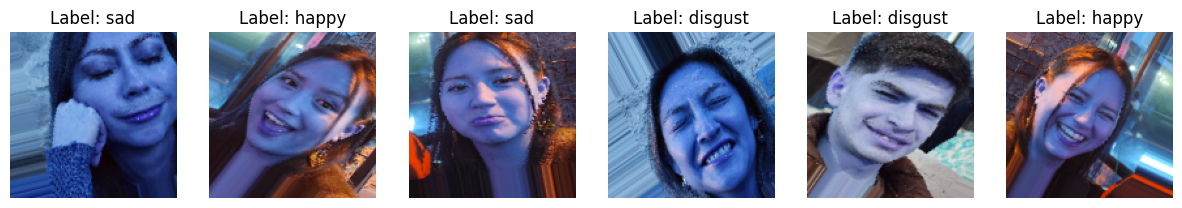

In [8]:
# Choose a random subset of samples to visualize
num_samples_to_visualize = 6
samples_to_visualize = random.sample(range(len(train_images)), num_samples_to_visualize)

plt.figure(figsize=(15, 5))
for i, sample_idx in enumerate(samples_to_visualize):
    plt.subplot(1, num_samples_to_visualize, i + 1)
    plt.imshow(train_images[sample_idx].astype(np.uint8))
    plt.title("Label: " + str(train_labels[sample_idx]))
    plt.axis('off')

plt.show()

 We need to Encode labels because deep learning models handel with numbers and not strings  

 ALSO , we need to change pixels (from 0 to 255) to  (from 0 to 1) because deep learning models are more confotebale small numbers  

"" chatgpt opinion : 
This division by 255 will rescale the pixel values to be between 0 and 1, which is a common practice for preparing image data for deep learning models. Make sure to apply this transformation to all the images in your dataset before training your model."""

In [9]:
from tensorflow.keras.layers import Dense ,GlobalAveragePooling2D, Input , Flatten , Conv2D , MaxPooling2D ,AveragePooling2D ,Dropout ,BatchNormalization
from tensorflow.keras import models 
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import classification_report 
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16 

# Assuming you have a list of label names like ['label1', 'label2', ...]
label_names = list(set(labels))   # Replace 'labels' with your actual list of label names

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder to the label names and transform the labels to integers
label_encoder.fit(label_names)
train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels) 


###
train_images , test_images = train_images/255.0 , test_images/255.0 




In [10]:
lob = set(train_labels)

count = []
for i in lob:
    filtered_arr = train_labels[train_labels == i]
    b = len(filtered_arr)
    count.append(b)

print(set(combined_labels))
print(lob)
print(count)
    


{'happy', 'angry', 'sad', 'neutral', 'disgust', 'fear', 'surprise'}
{0, 1, 2, 3, 4, 5, 6}
[872, 985, 848, 1043, 980, 944, 883]


# 3. We Bluid a CNN Model : 

1. Define Architucture. 
2. Vizualize the Architucture. 
3. Compile and train the model 

## - Define Architucture: 

In [11]:
from tensorflow.keras.applications import ResNet50 

In [12]:
input_shape = (128, 128, 3)  # Adjust this according to your input image dimensions and channels

# Load the pre-trained VGG16 model with custom input shape
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Create your custom output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) 
x = Dropout(0.3)(x) 
x = Dense(7, activation='softmax')(x)  # Replace 'num_classes' with the number of sentiment classes


94765736/94765736 [==============================] - 0s 0us/step


In [13]:
facial_exp_mode=models.Model(base_model.input,x)   


## - Vizualize the Architucture: 

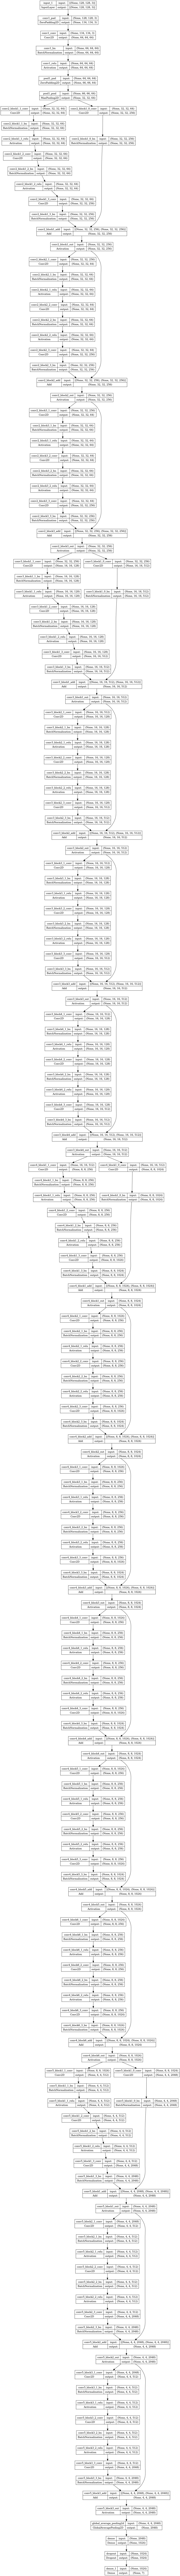

In [14]:
from keras.utils.vis_utils import plot_model 
from IPython.display import Image
filename = 'model_visualization.png'

# Plot and save the model architecture
plot_model(facial_exp_mode, to_file=filename, show_shapes=True, show_layer_names=True)
 

Image(filename=filename)

#### - Compile and train the model 

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
facial_exp_mode.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [16]:
r=facial_exp_mode.fit(train_images , train_labels , validation_data=(test_images , test_labels),
                    epochs=20 , callbacks=[early_stopping ])  

Epoch 1/20
205/205 [==============================] - 89s 127ms/step - loss: 1.3246 - accuracy: 0.5036 - val_loss: 10.1968 - val_accuracy: 0.1507
Epoch 2/20
205/205 [==============================] - 22s 109ms/step - loss: 0.7163 - accuracy: 0.7376 - val_loss: 1.9901 - val_accuracy: 0.1359
Epoch 3/20
205/205 [==============================] - 22s 107ms/step - loss: 0.4900 - accuracy: 0.8240 - val_loss: 3.7924 - val_accuracy: 0.1546
Epoch 4/20
205/205 [==============================] - 22s 108ms/step - loss: 0.3200 - accuracy: 0.8857 - val_loss: 2.3018 - val_accuracy: 0.2110
Epoch 5/20
205/205 [==============================] - 22s 108ms/step - loss: 0.2718 - accuracy: 0.9048 - val_loss: 3.4324 - val_accuracy: 0.3656
Epoch 6/20
205/205 [==============================] - 22s 108ms/step - loss: 0.2316 - accuracy: 0.9216 - val_loss: 1.2524 - val_accuracy: 0.6347
Epoch 7/20
205/205 [==============================] - 22s 107ms/step - loss: 0.1962 - accuracy: 0.9355 - val_loss: 0.5557 - val_a

### - Model evaluation 

In [17]:
pred=facial_exp_mode.predict(test_images) 
pred1 = [np.argmax(predi) for predi in pred] 

111/111 [==============================] - 3s 21ms/step


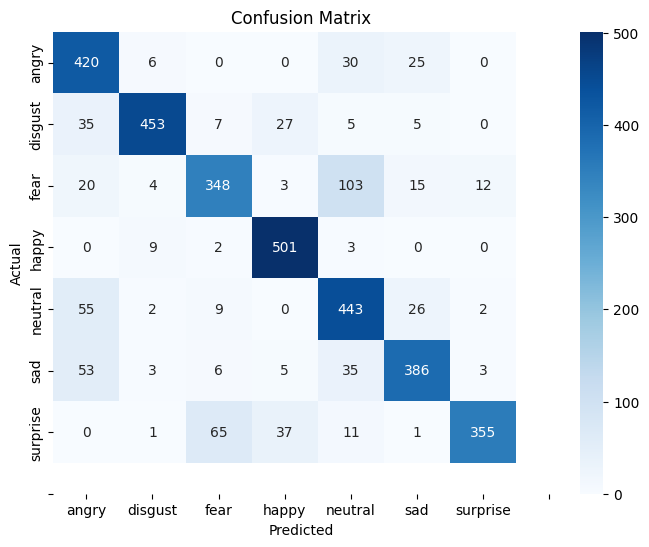

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define your label names
label_names = '''angry
disgust
fear
happy
neutral
sad
surprise
'''.split("\n")  # Replace with your actual label names

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, pred1)

# Create a heatmap for the confusion matrix with label names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [19]:
print(classification_report ( test_labels , pred1) ) 

              precision    recall  f1-score   support

           0       0.72      0.87      0.79       481
           1       0.95      0.85      0.90       532
           2       0.80      0.69      0.74       505
           3       0.87      0.97      0.92       515
           4       0.70      0.82      0.76       537
           5       0.84      0.79      0.81       491
           6       0.95      0.76      0.84       470

    accuracy                           0.82      3531
   macro avg       0.83      0.82      0.82      3531
weighted avg       0.83      0.82      0.82      3531



###  We see also Model mistake to understand :

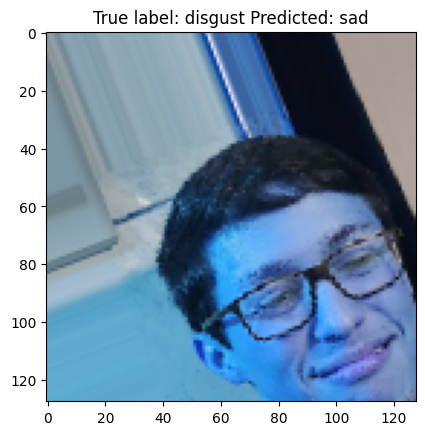

In [20]:
labels = '''angry
disgust
fear
happy
neutral
sad
surprise
'''.split("\n")
# Show some misclassified examples
misclassified_idx = np.where(pred1 != test_labels)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(test_images[i])
plt.title("True label: %s Predicted: %s" % (labels[test_labels[i]], labels[pred1[i]]));

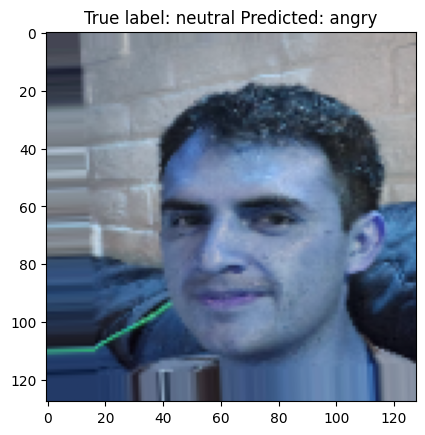

In [21]:
labels = '''angry
disgust
fear
happy
neutral
sad
surprise
'''.split("\n")
# Show some misclassified examples
misclassified_idx = np.where(pred1 != test_labels)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(test_images[i])
plt.title("True label: %s Predicted: %s" % (labels[test_labels[i]], labels[pred1[i]]));

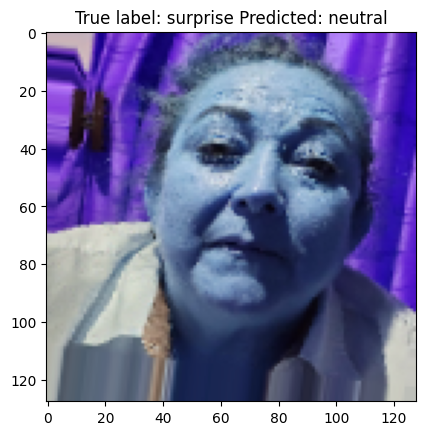

In [22]:
labels = '''angry
disgust
fear
happy
neutral
sad
surprise
'''.split("\n")
# Show some misclassified examples
misclassified_idx = np.where(pred1 != test_labels)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(test_images[i])
plt.title("True label: %s Predicted: %s" % (labels[test_labels[i]], labels[pred1[i]]));